In [65]:
import sys
import os

import h5py

import numpy as np

from astropy.io import fits

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from mrileyowens.stats import weighted_quantile

In [66]:
def compare():

    # Set common directories
    home = os.getcwd()
    data = f'{home}/data'
    results = f'{home}/results'

    catalog = fits.open(f'{data}/JADES_f775w_dropouts_Endsley2024.fits')

    with h5py.File(f'{results}/m_uv/endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5', 'r') as f:

        ids = f.keys() #catalog[1].data['ID']

        fig, ax = plt.subplots()

        for i, id in enumerate(ids):

            idx_ryan = np.where(catalog[1].data['ID'] == id)

            m_uv_ryan, m_uv_ryan_lower, m_uv_ryan_upper = catalog[1].data['Muv'][idx_ryan][0], catalog[1].data['Muv_l16'][idx_ryan][0], catalog[1].data['Muv_u84'][idx_ryan][0]

            m_uv_posterior, probabilities = f[id]['m_uv'][:], f[id]['probabilities'][:]
            #print(m_uv_posterior)

            m_uv_me, m_uv_me_lower, m_uv_me_upper = weighted_quantile(m_uv_posterior, probabilities, 0.5), weighted_quantile(m_uv_posterior, probabilities, 0.16), weighted_quantile(m_uv_posterior, probabilities, 0.84)

            ax.errorbar(m_uv_me, m_uv_ryan, xerr=[[abs(m_uv_me_lower - m_uv_me)],[abs(m_uv_me_upper - m_uv_me)]], yerr=[[abs(m_uv_ryan_lower - m_uv_ryan)], [abs(m_uv_ryan_upper - m_uv_ryan)]], 
                color='black')
            
            ax.axline((-20,-20), slope=1, color='red', linestyle='dashed')

            ax.set_xlabel(r'$M_\text{UV}$ (me)')
            ax.set_ylabel(r'$M_\text{UV}$ (Endsley et al. 2024)')

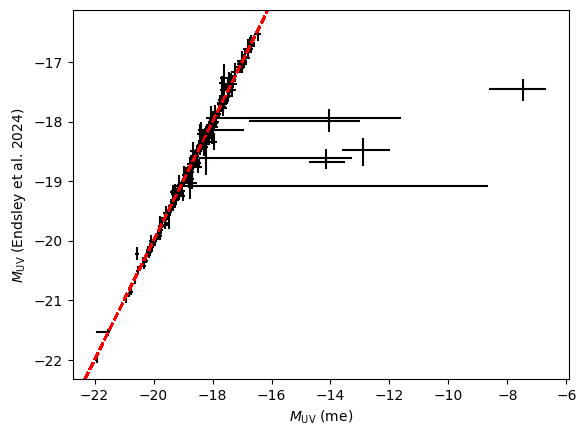

In [67]:
compare()